 #### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import mne
import bids
import scipy.signal as signal
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report, get_entities_from_fname
from mne.datasets.eegbci import standardize
from neuroCombat import neuroCombat


c:\Users\acer\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\acer\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\acer\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# BIDS conversion 

#### Dataset 1 (Finland)

Available in: https://osf.io/pehj9/

In [ ]:
import os # For path manipulation
import shutil # File manipulation
from mne_bids import print_dir_tree # To show the input/output directories structures inside this example
from sovabids.rules import apply_rules # Apply rules for conversion
from sovabids.convert import convert_them # Do the conversion
from sovabids.datasets import lemon_prepare # Download the dataset
import mne

# Erase PREP files...

exemplar_file = "Y:/datasets/HenryRailo/data/01_eyesOpen.set"
raw=mne.io.read_raw_eeglab(exemplar_file) #inspect line noise freq and channel names

source_path = "Y:/datasets/HenryRailo/data"
bids_path= "Y:/datasets/HenryRailo/bids"
rules_path = "Y:/datasets/HenryRailo/rules.yml"
mapping_path = "Y:/datasets/HenryRailo/mappings.yml"

apply_rules(source_path,bids_path,rules_path,mapping_path)
convert_them(mapping_path)
print_dir_tree(bids_path)

# Preprocessing

In [ ]:
# Adapted by Alberto Jaramillo-Jimenez from https://github.com/arnodelorme/eeg_pipelines/blob/master/mne/process_mne_template.py 
# This code wraps up sample codes from @yjmantilla, as well as pyprep, mne-icalabel, and autoreject documentation examples

def prepare_n(filename, keep_chans, epoch_length = 2,
              downsample = 500, line_noise = 60, normalization = False):
    """
    Run PREPARE_N pipeline for resting-state EEG signal preprocessing.
    Returns the preprocessed mne object in BIDS derivatives path. 
    
    Parameters
    ----------
    filename : str
        Full path of raw file and extension.
    keep_chans : list
        Channel names to keep. Can be defined in dataset['ch_names'].
    epoch_length : float
        The epoch length in seconds.
    downsample : float
        Sampling frequency (in Hz) for downsamlping.
    bandwidth : float
        The bandwidth of the multi taper windowing function in Hz.
    line_noise : float
        The line noise frequency (in Hz) to be removed using PyPREP.
    normalization : bool
        Returns both non-normalized and normalized .fif MNE objects.
    """
    
    # Wrapper function - open different eeg formats
    def mne_open(filename):
        """
        Function wrapper to read many eeg file types.
        Returns the Raw mne object or the RawEpoch object depending on the case. 
        """

        if '.cnt' in filename:
            return mne.io.read_raw_cnt(filename, preload=True)
        elif '.bdf'  in filename:
            return mne.io.read_raw_bdf(filename, preload=True)
        elif '.edf' in filename:
            return mne.io.read_raw_edf(filename, preload=True)
        else:
            return None
        
    # Get the derivatives path in BIDS format
    def get_derivative_path(layout,eeg_file,output_entity,suffix,output_extension,bids_root,derivatives_root):
        entities = layout.parse_file_entities(eeg_file)
        derivative_path = eeg_file.replace(bids_root,derivatives_root)
        derivative_path = derivative_path.replace(entities['extension'],'')
        derivative_path = derivative_path.split('_')
        desc = 'desc-' + output_entity
        derivative_path = derivative_path[:-1] + [desc] + [suffix]
        derivative_path = '_'.join(derivative_path) + output_extension 
        return derivative_path
    
    # Import dependencies
    import mne
    import os
    import sys
    import autoreject
    import numpy as np
    import bids
    from mne.datasets.eegbci import standardize
    from mne.preprocessing import ICA
    from mne_icalabel import label_components
    from pyprep.prep_pipeline import PrepPipeline

    # Import EEG raw recording + channel standarization
    raw = mne_open(filename)
    # Remove channels which are not needed
    standardize(raw) #standardize ch_names
    raw.pick_channels(keep_chans)
    ch_names = raw.info["ch_names"]
    eeg_index = mne.pick_types(raw.info, eeg=True, eog=False, meg=False)
    ch_names_eeg = list(np.asarray(ch_names)[eeg_index])

    # Add a montage to the data
    montage_kind = "standard_1005"
    montage = mne.channels.make_standard_montage(montage_kind)

    # Extract some info
    sample_rate = raw.info["sfreq"]
    
    # PyPREP
    # parameters
    prep_params = {
        "ref_chs": ch_names_eeg,
        "reref_chs": ch_names_eeg,
        "line_freqs": np.arange(line_noise, sample_rate / 2, line_noise)
        }
    prep = PrepPipeline(raw, prep_params, montage)
    prep.fit()
    raw = prep.raw
    

    # Filter the data
    raw.filter(l_freq=1, h_freq=None) # bandpassing 1 Hz

    # Extract epochs
    epochs = mne.make_fixed_length_epochs(raw, duration = epoch_length, preload=True)
    epochs.resample(downsample)

    # Automated epoch rejection
    ar = autoreject.AutoReject(random_state=11,n_jobs=1, verbose=False)
    ar.fit(epochs)
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
        

    filt_epochs = epochs_ar.copy().filter(l_freq=1.0, h_freq=100.0) # bandpassing 100 Hz (as in the MATLAB implementation of ICLabel)
    ica = ICA(
        n_components=15,
        max_iter="auto",
        method="infomax",
        random_state=97,
        fit_params=dict(extended=True))


    # Compute FastICA can be used if desired, here. MATLAB ICLabel implementation is based on extended infomax as above
    # ica = ICA(
    #     n_components=15,
    #     max_iter="auto",
    #     method="fastica",
    #     random_state=97)

    ica.fit(filt_epochs)

    # Annotate using mne-icalabel
    ic_labels = label_components(filt_epochs, ica, method="iclabel")
    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]] # a conservative approach suggested in mne-icalabel
    print(f"Excluding these ICA components: {exclude_idx}")

    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_epochs = epochs.copy()
    ica.apply(reconst_epochs, exclude=exclude_idx)
    

    # Post ICA automated epoch rejection (suggested by Autoreject authors)
    ar = autoreject.AutoReject(random_state=11, n_jobs=1, verbose=False)
    ar.fit(reconst_epochs)
    epochs_ar, reject_log = ar.transform(reconst_epochs, return_log=True)

    # Normalization of recording-specific variability (optional)
    

    # Export preprocessed data
    eeg_file_correct = eeg_file.replace('\\','/')
    derivatives_root = os.path.join(layout.root,'derivatives/prepare/')
    description = layout.get_dataset_description()


    reject_path = get_derivative_path(layout,eeg_file_correct,'reject','epo','.fif',bids_root,derivatives_root)
    reject_path = reject_path.replace('\\','/')
    fifname = os.path.basename(reject_path)
    fifpath = os.path.dirname(reject_path)
    os.makedirs(fifpath)
    epochs_ar.save(fifpath + '/' + fifname, split_naming='bids', overwrite=True)

Dataset 1 (Finland)

In [ ]:
dataset={
'layout':{'extension':'.set', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FZ', 'CZ', 'PZ', 'IZ', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FPZ', 'CPZ', 'POZ', 'OZ'],
    'path':'D:/EEGs/PhD_datasets/BIDS/finland'
}


#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/finland/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=finland #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None))
eegs = layout.get(**layoutd)

print(len(eegs), eegs)


In [ ]:
%%capture
for eeg_file in eegs:
    prepare_n(filename = eeg_file, epoch_length = 2, keep_chans = dataset['ch_names'], downsample = 500, line_noise = 50, normalization = True)

Dataset 2 (California)

In [ ]:
dataset={
'layout':{'extension':'.bdf', 'session':['hc', 'on'], 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'],
    'path':'D:/EEGs/PhD_datasets/BIDS/california/'
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/california/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=dataset #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None))
eegs = layout.get(**layoutd)
print(len(eegs), eegs)


In [ ]:
%%capture
for eeg_file in eegs:
    prepare_n(filename = eeg_file, epoch_length = 2, keep_chans = dataset['ch_names'], downsample = 500, line_noise = 60, normalization = True)

# Feature extraction

 #### Bandpower function by R.Vallat: Adapted from yasa.bandpower() to provide bandpower approximation from PSD array

In [48]:
def bandpower(data, sf, band, method='multitaper_average', window_sec=None, relative=True):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'multitaper_epochs' or 'multitaper_average'. Default is 'multitaper_average'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative/absolute band power after averagind the PSD vectors of each epoch by channel (default). 
      Can also return the relative/absolute bandpower for each epoch if "multitaper_epochs" is selected.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute PSD using multitaper average psd vectors over all epochs, or return the psd vector for each epoch
    if method == 'multitaper_average':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True, low_bias = True,
                                          normalization='full', verbose=0)
        psds_mean = psd.mean(0)
        psd = psds_mean

    elif method == 'multitaper_epochs':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True, low_bias = True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

Dataset 1 (Finland)

In [ ]:
# Dictionary with the info of the dataset
finland={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FZ', 'CZ', 'PZ', 'IZ', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FPZ', 'CPZ', 'POZ', 'OZ'],
    'path':"D:/EEGs/PhD_datasets/BIDS/finland/"
}

# Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/finland/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

# Task
task = 'rest' 

DATASET=finland #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

In [ ]:
# Extract relative bandpowers from Power Spectrum multitaper data
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(18)]], add_offset=False, on_mismatch='raise', verbose=None) # 18 WAS THE MINIMAL NUMBER OF EPOCHS ACROSS SUBJECTS
    epochs = epochs_c
    keep = ["Fp1", "Fp2", "O1", "O2", "FC2", "Fz", "F4", "P3", "Oz", "F7", "CP6", "FC1", "P8", "T7", "Cz", "F3",  "CP2", "FC6",  "C3", "FC5", "CP5", "AF4", "F8", "P4",  "CP1", "C4", "AF3", "T8",  "P7"] # We picked the common channels between datasets for simplicity
    epochs.pick_channels(keep)    
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        features = {}
        features['center'] = 'finland'
        features['participant_id'] = subject
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
#         features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
#         features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
#         features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
df = pd.DataFrame(dict_list)
print('FEATURE EXTRACTION, DONE')
df.to_csv('D:/EEGs/PhD_datasets/BIDS/finland/derivatives/sovaharmony/spectral_finland_5s_averaged.csv', index=False)
print('BANDPOWER CSV CREATED')

Dataset 2 (California)

In [ ]:
# Dictionary with the info of the dataset
california={
'layout':{'extension':'.fif', 'session':['hc', 'on'], 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'PZ', 'PO3', 'O1', 'OZ', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'FP2', 'FZ', 'CZ'],
    'path':"D:/EEGs/PhD_datasets/BIDS/california/"
}

#Path of the BIDS folder
bids_root = "D:/EEGs/PhD_datasets/BIDS/california/"
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'rest' 

DATASET=california #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'desc-reject' in k]

print(len(eegs), eegs)

In [ ]:
# Extract relative bandpowers from Power Spectrum multitaper data
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    standardize(epochs) #standardize ch_names
    epochs = epochs.filter(l_freq=1, h_freq=30) #bandpassing 1-30Hz
    downsample = 500 #downsampling to 500Hz
    epochs.resample(downsample)
    sf = downsample
    epochs_c = mne.concatenate_epochs(epochs_list = [epochs[:][range(18)]], add_offset=False, on_mismatch='raise', verbose=None) # 18 WAS THE MINIMAL NUMBER OF EPOCHS ACROSS SUBJECTS
    epochs = epochs_c
    keep = ["Fp1", "Fp2", "O1", "O2", "FC2", "Fz", "F4", "P3", "Oz", "F7", "CP6", "FC1", "P8", "T7", "Cz", "F3",  "CP2", "FC6",  "C3", "FC5", "CP5", "AF4", "F8", "P4",  "CP1", "C4", "AF3", "T8",  "P7"] # We picked the common channels between datasets for simplicity
    epochs.pick_channels(keep)    
    nepochs,nchannels,npoints = epochs._data.shape
    correct_channels = epochs.info['ch_names']
    epochs.reorder_channels(correct_channels)
    channels = epochs.info['ch_names']
    for ch,ch_label in enumerate(channels):
        features = {}
        features['center'] = 'california'
        features['participant_id'] = subject
        features['channel'] = ch_label
        features['delta'] = bandpower(epochs.get_data()[:,ch,:], sf, [1, 4], 'multitaper_average', relative=True)
        features['theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        features['alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True)
        features['beta'] = bandpower(epochs.get_data()[:,ch,:], sf, [13, 30], 'multitaper_average', relative=True)
        features['pre_alpha'] = bandpower(epochs.get_data()[:,ch,:], sf, [5.5, 8], 'multitaper_average', relative=True)
        features['slow_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [4, 5.5], 'multitaper_average', relative=True)
#         features['alpha1'] = bandpower(epochs.get_data()[:,ch,:], sf, [8.5, 10.5], 'multitaper_average', relative=True)
#         features['alpha2'] = bandpower(epochs.get_data()[:,ch,:], sf, [10.5, 12.5], 'multitaper_average', relative=True)
#         features['beta1'] = bandpower(epochs.get_data()[ep,ch,:], sf, [12.5, 18.5], 'multitaper_average', relative=True)
#         features['beta2'] = bandpower(epochs.get_data()[ep,ch,:], sf, [18.5, 21], 'multitaper_average', relative=True)
#         features['beta3'] = bandpower(epochs.get_data()[ep,ch,:], sf, [21, 30], 'multitaper_average', relative=True)
        features['alpha_theta'] = bandpower(epochs.get_data()[:,ch,:], sf, [8, 13], 'multitaper_average', relative=True) / bandpower(epochs.get_data()[:,ch,:], sf, [4, 8], 'multitaper_average', relative=True)
        dict_list.append(features)
df = pd.DataFrame(dict_list)
print('FEATURE EXTRACTION, DONE')
df.to_csv('D:/EEGs/PhD_datasets/BIDS/california/derivatives/sovaharmony/spectral_california_5s_averaged.csv', index=False)
print('BANDPOWER CSV CREATED')

#### Merge multi-site features

In [2]:
# Read the Dataset 1 (Finland) participants.tsv metadata and merge demographic variables with features (for ComBat control of biological covariates)

metadata_cols = ['participant_id', 'group' , 'age', 'gender'] # names of the metadata columns to be merged

participants_file = r"D:\EEGs\PhD_datasets\BIDS\finland\participants.tsv"
participants_df = pd.read_csv(participants_file, sep="\t", converters = {'subject': str})
participants_df.columns= participants_df.columns.str.lower() # To set all the column names in lower case
participants_df['participant_id'] = participants_df['participant_id'].str.replace('sub-', '')  # Drop the "sub-" prefix used for BIDS


features_file = r"D:\EEGs\PhD_datasets\BIDS\finland\derivatives\sovaharmony\spectral_finland_5s_averaged.csv"
features_df = pd.read_csv(features_file, sep=",", converters = {'subject': str})
features_df.rename(columns = {'subject':'participant_id'}, inplace = True) 
df_1 = pd.DataFrame(pd.merge(participants_df[metadata_cols], features_df, on="participant_id")) # Merge metadata columns with the features into a new data frame
df_1['participant_id'] = 'fin-' + df_1['participant_id'].astype(str) # Add a prefix in the participant_id with the initials of the batch center (fin for Finland)

In [3]:
# Read the Dataset 2 (California) participants.tsv metadata and merge demographic variables with features (for ComBat control of biological covariates)

participants_file = r"D:\EEGs\PhD_datasets\BIDS\california\participants.tsv"
metadata_cols = ['participant_id', 'age', 'gender']

participants_df = pd.read_csv(participants_file, sep="\t")
participants_df['participant_id'] = participants_df['participant_id'].str.replace('sub-', '')  # Drop the "sub-" prefix used for BIDS


features_file = r"D:\EEGs\PhD_datasets\BIDS\california\derivatives\sovaharmony\spectral_california_5s_averaged.csv"
features_df = pd.read_csv(features_file, sep=",")
features_df.rename(columns = {'subject':'participant_id'}, inplace = True)
df_2 = pd.DataFrame(pd.merge(participants_df[metadata_cols], features_df, on="participant_id")) # Merge metadata columns with the features into a new data frame
df_2['participant_id'] = 'cal-' + df_2['participant_id'].astype(str) # Add a prefix in the participant_id with the initials of the batch center (cal for California)

# Merge Dataframes 1 and 2 for ComBat harmonization of spectral features
merged_df = df_1.append(df_2)

In [4]:
# Log 10 transformation of the spectral features
merged_df[["delta","theta", "alpha","beta", "pre_alpha","slow_theta","alpha_theta"]] = merged_df[["delta","theta", "alpha","beta", "pre_alpha","slow_theta","alpha_theta"]].apply(np.log)

In [5]:
# merged_df.to_csv('PATH', index=False)  #### HERE PUT THE STORAGE PATH FOR THIS CSV

# ComBat Harmonization

Some minor transformations on tabular data

In [5]:
### Group the channel * bandpower values by participant_id (having each participant in a row and all bandpower*channels in the columns)
df_log_w = pd.pivot_table(merged_df, index = ['participant_id', 'group' , 'age', 'gender', 'center'], columns = ['channel'],values = ["delta","theta", "alpha","beta", "pre_alpha","slow_theta","alpha_theta"])
df_log_w.columns = ['_'.join(col).strip() for col in df_log_w.columns.values]
df_log_w = df_log_w.reset_index(drop = False)

In [6]:
df_log_w = df_log_w.dropna(axis=1)  ## ESTO SE DEBE BORRAR 
original_metadata = df_log_w.iloc[:, 0:5]  ## As all bandpowers are considered as "data" input for ComBat, let's take the remaining metadata from the original file (i.e. participant_id, group, age, gender, center)

In [7]:
### Recode categorical variables into numeric for ComBat
gender=["f", "m"]
dummy_vars=[1,2]
df_log_w['gender'] = df_log_w['gender'].replace(gender, dummy_vars)

center=["finland", "california"]
dummy_vars=[1,2]
df_log_w['center'] = df_log_w['center'].replace(center, dummy_vars)

group=["hc", "pd"]
dummy_vars=[0,1]
df_log_w['group'] = df_log_w['group'].replace(group, dummy_vars)

In [8]:
### Specifying the batch ('center' variable) as well as biological covariates to preserve (i.e. gender, group, age):

covars = {'batch':df_log_w['center'],
          'gender':df_log_w['gender'],
          'group': df_log_w['group'],
          'age': df_log_w['age']}
covars = pd.DataFrame(covars)


# To specify names of the variables that are categorical:
categorical_cols = ['gender', 'group']

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

In [9]:
### Transpose the input data matrix to get features in rows and subjects in columns
data = df_log_w.loc[:, ~df_log_w.columns.isin(['participant_id','center', 'age', 'group', 'gender'])].T.reset_index(drop = True).to_numpy()

In [10]:
### Harmonization step:
data_combat = neuroCombat(dat=data,
    covars=covars,
    batch_col=batch_col,
    categorical_cols=categorical_cols)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [11]:
# Reorganize the data into a new dataframe with metadata
column_names = df_log_w.columns[5:]  # HAY ALGUNA FORMA MÁS ELEGANTE DE HACER ESTO????
combat_df = pd.DataFrame(data_combat.T, columns = column_names + '_combat')
harmonized_df = pd.concat([original_metadata, combat_df], axis=1)

In [12]:
harmonized_df

,participant_id,group,age,gender,center,alpha_AF3_combat,alpha_AF4_combat,alpha_C3_combat,alpha_C4_combat,alpha_CP1_combat,...,theta_Oz_combat,theta_P3_combat,theta_P4_combat,theta_P7_combat,theta_P8_combat,theta_PO3_combat,theta_PO4_combat,theta_Pz_combat,theta_T7_combat,theta_T8_combat
0,cal-hc1,hc,54,f,california,-1.420234,-1.442321,-1.616009,-1.797987,-1.576173,...,-2.242207,-2.357046,-2.196129,-2.006370,-2.140596,-2.548760,-2.285936,-2.182781,-2.175655,-1.876136
1,cal-hc10,hc,59,f,california,-1.787939,-1.565608,-1.441073,-1.123385,-1.658330,...,-1.789592,-2.412431,-2.513762,-2.057665,-2.421697,-2.303820,-2.174009,-2.419452,-1.910187,-2.106421
2,cal-hc18,hc,57,m,california,-0.770126,-0.795836,-0.960305,-0.530313,-0.633049,...,-2.156007,-2.239999,-2.317434,-1.937289,-2.122439,-2.106401,-2.293978,-2.398328,-2.156871,-1.993102
3,cal-hc2,hc,50,f,california,-1.635125,-1.420398,-1.574514,-1.683779,-1.425922,...,-1.968136,-2.074948,-2.097968,-2.084581,-1.997803,-1.958470,-1.936655,-1.956911,-2.322298,-1.896136
4,cal-hc20,hc,68,m,california,-2.257067,-2.216028,-1.965314,-1.886837,-1.894635,...,-1.615790,-1.787233,-1.529224,-1.667760,-1.430750,-1.832702,-1.595270,-1.555604,-1.804325,-1.560856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,fin-035,hc,76,f,finland,-1.221993,-1.675779,-1.144223,-1.383346,-1.412788,...,-1.887401,-1.710027,-1.679785,-1.680224,-1.813658,-1.962743,-1.868983,-1.788975,-1.737371,-1.820941
65,fin-036,pd,66,m,finland,-1.896548,-1.838168,-1.510047,-1.442522,-1.523960,...,-1.517217,-1.769291,-1.763323,-1.542475,-1.769030,-1.680325,-1.699350,-1.704308,-1.652234,-1.712462
66,fin-037,hc,61,f,finland,-0.622114,-0.771409,-1.125911,-1.035759,-0.804458,...,-2.288821,-2.678599,-2.919359,-2.356302,-2.574727,-2.653921,-2.906977,-3.006220,-2.316189,-2.357157
67,fin-038,pd,78,m,finland,-1.701434,-1.635764,-1.719683,-1.738223,-1.773608,...,-0.652494,-0.875961,-0.719646,-0.952277,-0.768813,-1.011711,-0.668850,-0.736706,-0.995829,-1.038765


In [ ]:
# harmonized_df.to_csv('PATH') #### SET THE PATH HERE 

# Classification

In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBClassifier

In [14]:
data = harmonized_df
data_xgb = data.drop(columns=['participant_id', 'age', 'gender', 'center'])

group=["hc", "pd"]
dummy_vars=[0,1]
data_xgb['group'] = data_xgb['group'].replace(group, dummy_vars)

In [15]:
from sklearn.model_selection import train_test_split

X = data_xgb
y = data_xgb['group']
X = X.drop(['group'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
lr = XGBClassifier(random_state=42)

sfs = SFS(lr, 
          k_features="best", 
          forward=True, 
          floating=False, 
          scoring='f1',
          verbose=2,
          cv=5,
          n_jobs = -1)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    9.4s finished

[2022-12-05 17:42:32] Features: 1/224 -- score: 0.8347474747474747[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 208 out of 223 | elapsed:    5.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 223 out of 223 | elapsed:    5.8s finished

[2022-12-05 17:42:37] Features: 2/224 -- score: 0.8262626262626263[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 207 out of 222 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:    5.6s finished

[2022-12-05 17

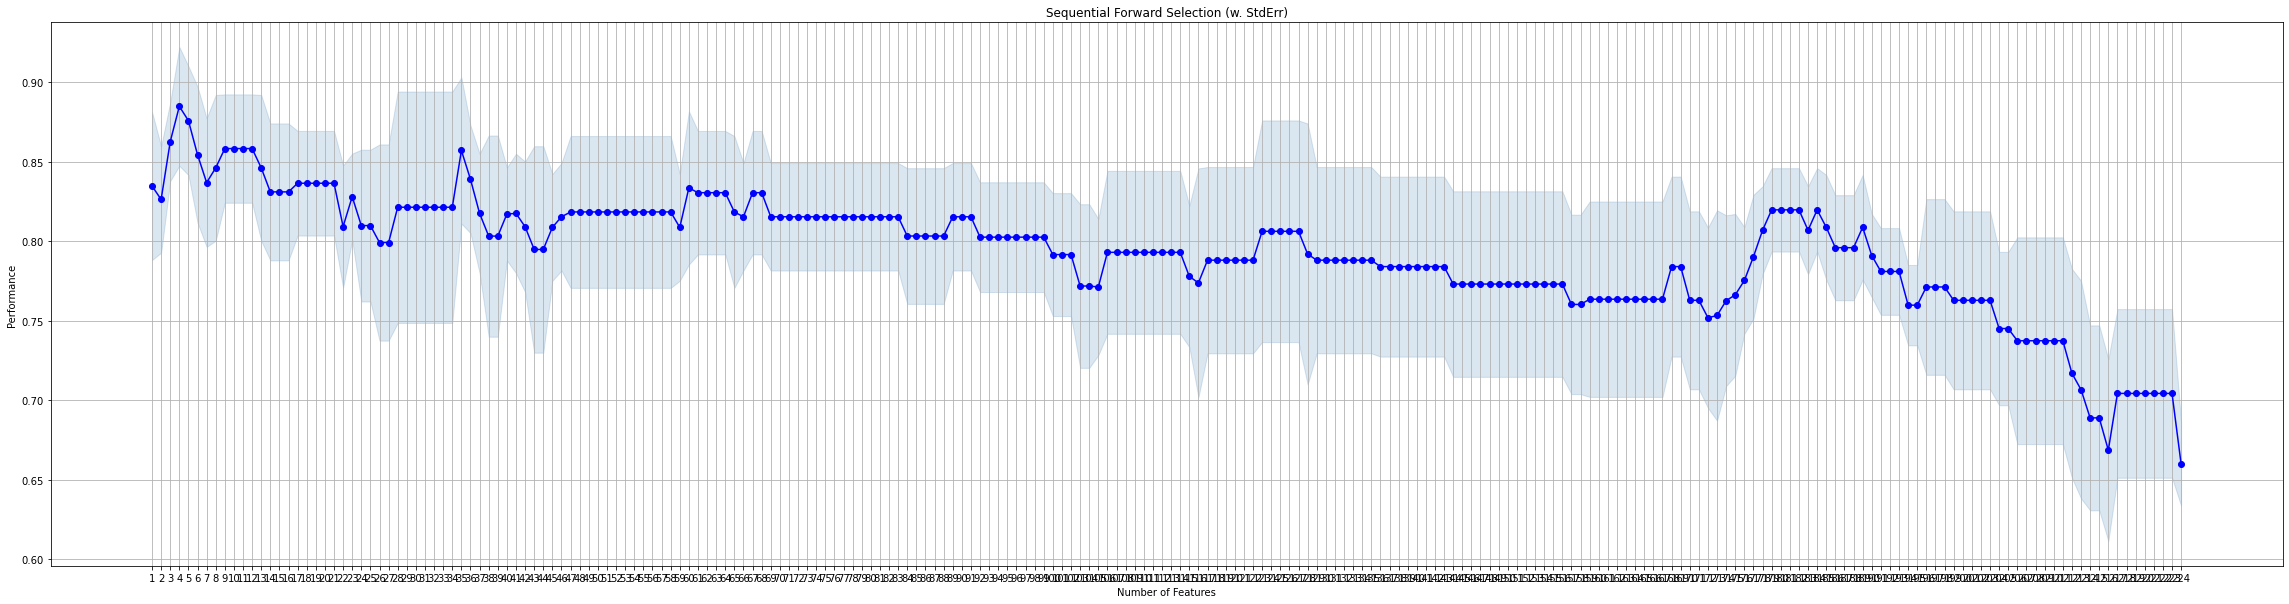

('alpha_F4_combat', 'pre_alpha_O1_combat', 'slow_theta_FC6_combat', 'slow_theta_Fp1_combat')
0.8848706848706849


In [18]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,10)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()
print(sfs.k_feature_names_)
print(sfs.k_score_)

In [24]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve


In [25]:
selected_feats = list(sfs.k_feature_names_)

Xsel = X_test[selected_feats]
Xsel

,alpha_F4_combat,pre_alpha_O1_combat,slow_theta_FC6_combat,slow_theta_Fp1_combat
39,-1.149496,-1.656425,-3.308822,-2.892551
35,-2.525929,-2.635504,-3.144698,-2.894119
65,-1.751163,-2.068889,-2.770702,-2.977267
7,-3.274595,-2.291501,-3.736387,-4.232390
14,-1.066912,-1.501330,-3.067611,-2.395369
18,-1.400344,-1.615793,-2.986834,-2.870247
10,-2.205094,-2.595288,-3.409217,-2.601407
19,-1.169366,-2.101860,-3.560944,-2.797287
29,-0.817578,-2.655098,-3.182322,-1.846911
24,-2.200455,-2.466811,-2.805982,-2.264280


In [26]:
from sklearn.model_selection import StratifiedKFold

cv    = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
folds = [(train,test) for train, test in cv.split(Xsel, y_test)]
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [28]:
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}

In [29]:
plt.rcParams["figure.figsize"] = (10,10)
dtest = xgb.DMatrix(Xsel, label=y_test)
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(Xsel.iloc[train,:], label=y_test.iloc[train])
    dval   = xgb.DMatrix(Xsel.iloc[test,:], label=y_test.iloc[test])
    model  = xgb.train(
        dtrain                = dtrain,
        params                = params, 
        evals                 = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round       = 1000,
        verbose_eval          = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds              = model.predict(sets[i])
        labels               = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
kind = 'test'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(4):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 600,
    height      = 600,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')

  0%|          | 0/5 [00:00<?, ?it/s]

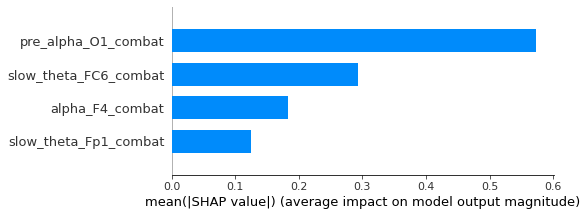

In [30]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xsel)
shap.summary_plot(shap_values, Xsel, plot_type="bar")